# Evaluating Credit Card Fraud on Streamed Data with Spark 

Spark Setup

In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')

# The SparkContext is the entry point to the Spark runtime
# SUPER IMPORTANT! DOES NOT WORK WITHOUT IT!
sc = pyspark.SparkContext(conf=conf)

# Start a Spark session to be closed at the end of the notebook
spark = SparkSession(sc)

Data Import, Cleaning, and Transformation

In [2]:
# Imports
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

In [3]:
# Read in csv data into spark 
data = spark.read.format('csv').options(header='true', inferSchema='true').load(
    'creditcard.csv')
#Confirm the data has been loaded
display(data)

DataFrame[Time: decimal(10,0), V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, Class: int]

In [4]:
# Glance at the data's schema: columns and their datatypes
data.printSchema()

root
 |-- Time: decimal(10,0) (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double

In [5]:
# Drop the time column 
data = data.drop('Time')

In [6]:
# Rename the target variable to ease future labelCol assignments in model building with SparkMLlib
data = data.withColumnRenamed('Class', 'label')

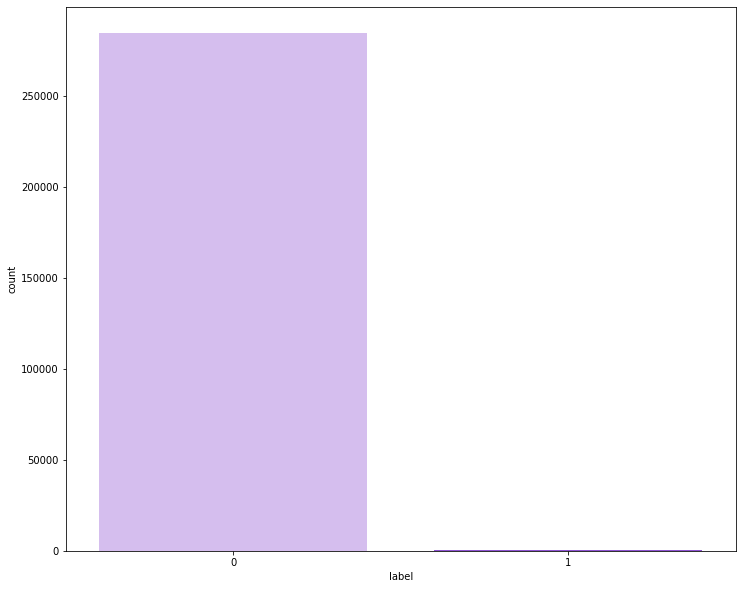

In [7]:
# Plot the distribution of the target variable by converting the Spark DataFrame into Pandas DataFrame 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
data_pd = data.toPandas()
plt.figure(figsize=(12, 10))
purple = ['#d4b6f6', '#8c3ee6']
sns.countplot(x='label', data=data_pd, order=data_pd['label'].value_counts().index, palette=purple)

In [8]:
# Calculate the instances in each class for the target variable; Dataset is clearly very unbalalanced
data.groupby('label').count().toPandas()

,label,count
0,1,492
1,0,284315


In [9]:
# Count transactions where the monetary value is less than 0
data.filter(data['Amount'] <= 0).count()

1825

In [10]:
# Only keep transactions with actual transaction value ('Amount')
data2 = data.filter(data['Amount'] > 0)
data2_pd = data2.toPandas()

In [11]:
# Confirm the instances have been dropped
print(data.count(), len(data.columns))
print(data2.count(), len(data2.columns))

284807 30
282982 30


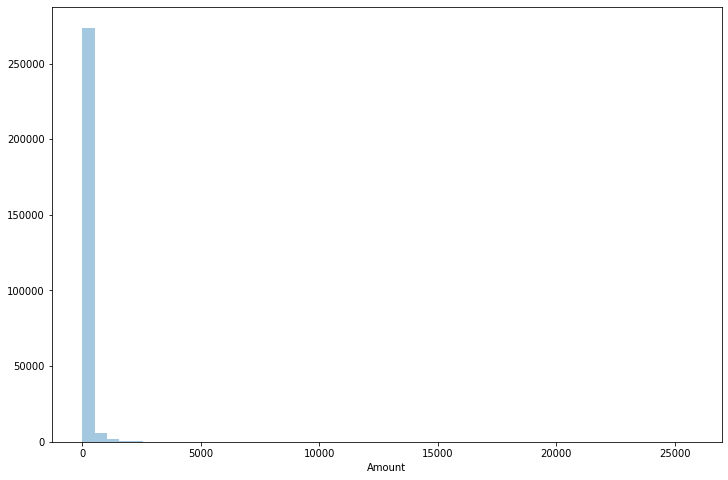

In [12]:
# Plot distribution of monetary value attached to non-fraud transactions 
plt.figure(figsize=(12,8))
sns.distplot(data2_pd[data2_pd['label'] == 0]['Amount'], kde=False)

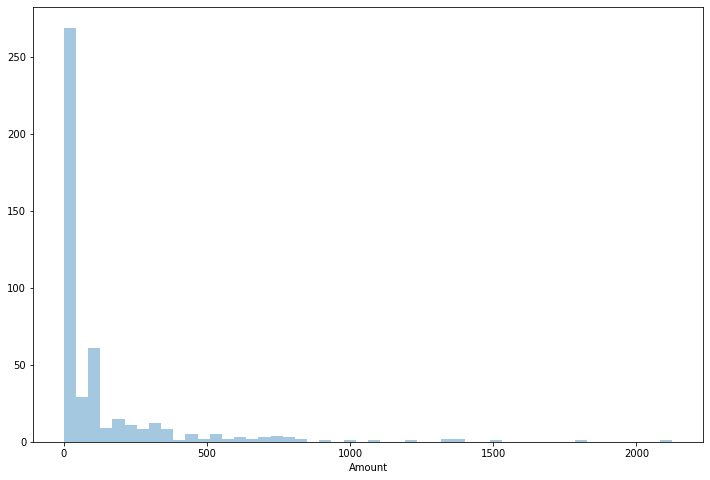

In [13]:
# Plot the distribution of monetary value attached to fraud transactions 
plt.figure(figsize=(12,8))
sns.distplot(data2_pd[data2_pd['label'] == 1]['Amount'], kde=False)

In [14]:
# Look at descriptive statistics for non-fraud 
data2.filter(data['label'] == 0).describe('Amount').show()

+-------+------------------+
|summary|            Amount|
+-------+------------------+
|  count|            282517|
|   mean|  88.8529258062013|
| stddev|250.80017900647618|
|    min|              0.01|
|    max|          25691.16|
+-------+------------------+



In [15]:
# Look at descriptive statistics for fraud 
data2.filter(data['label'] == 1).describe('Amount').show()

+-------+------------------+
|summary|            Amount|
+-------+------------------+
|  count|               465|
|   mean|129.30746236559136|
| stddev|262.29878118844374|
|    min|              0.01|
|    max|           2125.87|
+-------+------------------+



In [16]:
# Separate non-fraud (majority class) and fraud (minority class) to downsample and upsample respectively
data2_majority = data2.filter(data['label'] == 0)
data2_minority = data2.filter(data['label'] == 1)

In [17]:
# Set the seed to ensure reproducibility 
seed = 42

# Downsample the majority class to 50% of original dataset size 
data2_downsample = data2_majority.sample(True, 0.5, seed=seed)
print(data2_downsample.count())

141452


In [18]:
# Upsample the minority class to equal the downsampled majority class 
data2_upsample = data2_minority.sample(True, (data2_downsample.count() / data2_minority.count()), seed=seed)
print(data2_upsample.count())

141317


In [19]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

# Calculate the mean and stddev for non-fraud
data_stats_downsample = data2_downsample.select(
                                _mean(col('Amount')).alias('mean'),
                                _stddev(col('Amount')).alias('std')
                                ).collect()

mean_downsample = data_stats_downsample[0]['mean']
std_downsample = data_stats_downsample[0]['std']

print(mean_downsample , std_downsample)

# Calculate outlier threshold as mean + 3 * stddev
outliers_downsample = mean_downsample + (3 * std_downsample)
print(outliers_downsample)

88.57349121965463 258.5098814157115
864.1031354667891


In [20]:
# Number of instances above the outlier threshold for non-fraud
data2_downsample.filter(data2_majority['Amount'] > outliers_downsample).count()

1906

In [21]:
# Calculate the mean and stddev for fraud
data_stats_upsample = data2_upsample.select(
    _mean(col('Amount')).alias('mean'),
    _stddev(col('Amount')).alias('std')
).collect()

mean_upsample = data_stats_upsample[0]['mean']
std_upsample = data_stats_upsample[0]['std']

print(mean_upsample , std_upsample)

# Calculate outlier threshold as mean + 3 * stddev
outliers_upsample = mean_upsample + (3 * std_upsample)
print(outliers_upsample)

130.10425766183468 265.57539795950044
926.8304515403361


In [22]:
# Number of instances above the outlier threshold for fraud
data2_upsample.filter(data2_upsample['Amount'] > outliers_upsample).count()

3169

In [23]:
# Despite identifying potential outliers, because the data is primarily the results of PCA, we do not have enough context
# to rule out any transactions, and the descriptive statistics do not show any instances where the Amount is unreasonable
# for a credit card transaction

# Join together the downsampled and upsampled data
data3 = data2_downsample.unionAll(data2_upsample)

In [24]:
# Size of new dataset
data3.count()

282769

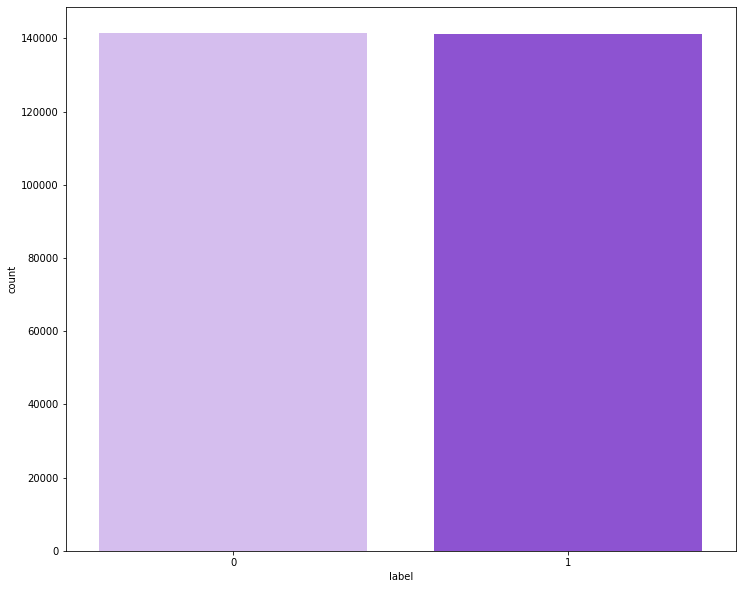

In [25]:
# Plot distribution of resampled dataset target variable to confirm data is balanced
data3_pd = data3.toPandas()
plt.figure(figsize=(12, 10))
purple = ['#d4b6f6', '#8c3ee6']
sns.countplot(x='label', data=data3_pd, order=data3_pd['label'].value_counts().index, palette=purple)

In [26]:
from pyspark.sql.functions import rand

# Shuffle the data 
data3 = data3.orderBy(rand(seed=seed))

Modeling

In [27]:
# Randomly separate the data into train and test sets for modeling 
train, test = data3.randomSplit([0.8, 0.2], seed=seed)

In [28]:
# Save the test data in an external distributed parquet directory for later streaming 
test.write.parquet('test.parquet')

In [29]:
# Randomly split the train data into train and validation for modeling 
train, validation = train.randomSplit([0.8, 0.2], seed=seed)

Logistic Regression

In [31]:
# Build the pipeline for our LogisticRegression model
# Vectorize the features to be used for the model
va = VectorAssembler(inputCols=train.columns[:29], outputCol='features')
lr = LogisticRegression()
pl = Pipeline(stages=[va, lr])

In [32]:
# Specify model parameters to tune  
paramGrid_lr = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.maxIter, [10, 100]).build()

In [33]:
# Run 5-fold cross validation using the pipeline as the estimator, estimatorParamMaps as the parameters to optimize
# and evaluator as BinaryClassification Evaluator
cv_lr = CrossValidator(estimator=pl,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5,
                          seed=seed)

In [34]:
# Fit the model on the train data
cvModel_lr = cv_lr.fit(train)

In [35]:
# Print the values of the optimized parameters 
print('Optimal Regularization Parameter: ', cvModel_lr.bestModel.stages[-1]._java_obj.getRegParam())
print('Optimal Iteration Parameter: ', cvModel_lr.bestModel.stages[-1]._java_obj.getMaxIter())

Optimal Regularization Parameter:  0.01
Optimal Iteration Parameter:  10


In [36]:
# Print evaluation metrics for the selected logistic regression model on the training data
trainingSummary_lr = cvModel_lr.bestModel.stages[-1].summary

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary_lr.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary_lr.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary_lr.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary_lr.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary_lr.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy_lr = trainingSummary_lr.accuracy
falsePositiveRate_lr = trainingSummary_lr.weightedFalsePositiveRate
truePositiveRate_lr = trainingSummary_lr.weightedTruePositiveRate
fMeasure_lr = trainingSummary_lr.weightedFMeasure()
precision_lr = trainingSummary_lr.weightedPrecision
recall_lr = trainingSummary_lr.weightedRecall
print("\nAccuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy_lr, falsePositiveRate_lr, truePositiveRate_lr, fMeasure_lr, precision_lr, recall_lr))

False positive rate by label:
label 0: 0.11230639693337174
label 1: 0.011690171881886294

True positive rate by label:
label 0: 0.9883098281181137
label 1: 0.8876936030666283

Precision by label:
label 0: 0.8984634801073761
label 1: 0.986931244303205

Recall by label:
label 0: 0.9883098281181137
label 1: 0.8876936030666283

F-measure by label:
label 0: 0.9412474553505845
label 1: 0.93468573561663

Accuracy: 0.9381401155660638
FPR: 0.06213668438132183
TPR: 0.9381401155660638
F-measure: 0.9379756212827575
Precision: 0.9425756727239858
Recall: 0.9381401155660638


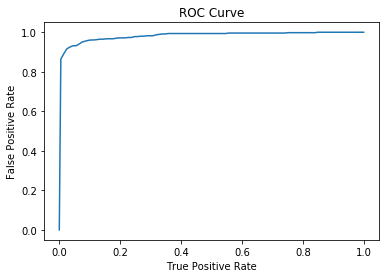

Training set ROC: 0.981786366140881


In [37]:
# Plot the ROC curve for the logistic regression model on the training data
roc_lr = trainingSummary_lr.roc.toPandas()
plt.plot(roc_lr['FPR'],roc_lr['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set ROC: ' + str(trainingSummary_lr.areaUnderROC))

In [38]:
# Generate logistic regression predictions on validation dataset
pred_lr = cvModel_lr.transform(validation)

In [39]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create both evaluators to generate multiple evaluation metrics
evaluator = MulticlassClassificationEvaluator()
evaluator_bin = BinaryClassificationEvaluator()

In [40]:
# Print performance metrics for the logistic regression model on the validation dataset
print("Test_SET Accuracy: " + str(evaluator.evaluate(pred_lr, {evaluator.metricName: "accuracy"})))
print("Test_SET Precision: " + str(evaluator.evaluate(pred_lr, {evaluator.metricName: "weightedPrecision"})))
print("Test_SET Recall: " + str(evaluator.evaluate(pred_lr, {evaluator.metricName: "weightedRecall"})))
print("Test_SET f1 score: " + str(evaluator.evaluate(pred_lr, {evaluator.metricName: "f1"})))
print("Test_SET Area Under ROC: " + str(evaluator_bin.evaluate(pred_lr, {evaluator.metricName: "areaUnderROC"})))

Test_SET Accuracy: 0.9355066702005478
Test_SET Precision: 0.9403181546019669
Test_SET Recall: 0.9355066702005478
Test_SET f1 score: 0.935346375013639
Test_SET Area Under ROC: 0.9827235642327962


Decision Tree

In [41]:
# Create DecisionTree model to add to a pipeline
clf = DecisionTreeClassifier(seed=seed)

In [42]:
# Create pipeline for decision tree model
pl_clf = Pipeline(stages=[va, clf])

In [43]:
# Specify model parameters to tune 
paramGrid_clf = ParamGridBuilder().addGrid(clf.maxDepth, [5, 6, 7, 8]) \
                                  .addGrid(clf.minInstancesPerNode, [1, 2, 3, 4]) \
                                  .addGrid(clf.minInfoGain, [0, 0.01, 0.1]) \
                                  .build()

In [44]:
# Run 5-fold cross validation using the pipeline as the estimator, estimatorParamMaps as the parameters to optimize
# and evaluator as BinaryClassification Evaluator
crossval_clf = CrossValidator(estimator=pl_clf,
                          estimatorParamMaps=paramGrid_clf,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5,
                          seed=seed)

In [45]:
# Fit the model on the train data
cvModel_clf = crossval_clf.fit(train)

In [46]:
# Print values of optimized parameters
print('Optimal Maximum Depth Parameter: ', cvModel_clf.bestModel.stages[-1]._java_obj.getMaxDepth())
print('Optimal Minimum Instances Per Node Parameter: ', cvModel_clf.bestModel.stages[-1]._java_obj.getMinInstancesPerNode())
print('Optimal Minimum Info Gain Parameter: ', cvModel_clf.bestModel.stages[-1]._java_obj.getMinInfoGain())

Optimal Maximum Depth Parameter:  8
Optimal Minimum Instances Per Node Parameter:  3
Optimal Minimum Info Gain Parameter:  0.0


In [47]:
# Generate decision tree predictions on validation dataset
pred_clf = cvModel_clf.transform(validation)

In [48]:
# Print performance metrics for decision tree model on validation dataset
print("Test_SET Accuracy: " + str(evaluator.evaluate(pred_clf, {evaluator.metricName: "accuracy"})))
print("Test_SET Precision: " + str(evaluator.evaluate(pred_clf, {evaluator.metricName: "weightedPrecision"})))
print("Test_SET Recall: " + str(evaluator.evaluate(pred_clf, {evaluator.metricName: "weightedRecall"})))
print("Test_SET f1 score: " + str(evaluator.evaluate(pred_clf, {evaluator.metricName: "f1"})))
print("Test_SET Area Under ROC: " + str(evaluator_bin.evaluate(pred_clf, {evaluator.metricName: "areaUnderROC"})))

Test_SET Accuracy: 0.9800777453838678
Test_SET Precision: 0.9801246971237785
Test_SET Recall: 0.9800777453838678
Test_SET f1 score: 0.9800767964540148
Test_SET Area Under ROC: 0.9469851026044167


Random Forest

In [49]:
from pyspark.ml.classification import RandomForestClassifier

# Random Forest Classifier

# Repeat the process of building the model, selecting parameters to be tuned, running cross validation, fitting the model
# getting values for optimized parameters, generating predictions, and printing performance metrics

rf = RandomForestClassifier(seed=seed)

pl_rf = Pipeline(stages=[va, rf])

paramGrid_rf = ParamGridBuilder().addGrid(rf.maxDepth, [5, 6, 7, 8]) \
                                  .addGrid(rf.minInstancesPerNode, [1, 2, 3, 4]) \
                                  .addGrid(rf.numTrees, [20, 40, 60]) \
                                  .build()

crossval_rf = CrossValidator(estimator=pl_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5,
                          seed=seed)

cvModel_rf = crossval_rf.fit(train)

print('Optimal Maximum Depth Parameter: ', cvModel_rf.bestModel.stages[-1]._java_obj.getMaxDepth())
print('Optimal Minimum Instances Per Node Parameter: ', cvModel_rf.bestModel.stages[-1]._java_obj.getMinInstancesPerNode())
print('Optimal Number of Trees Parameter: ', cvModel_rf.bestModel.stages[-1]._java_obj.getNumTrees())

pred_rf = cvModel_rf.transform(validation)

print("Test_SET Accuracy: " + str(evaluator.evaluate(pred_rf, {evaluator.metricName: "accuracy"})))
print("Test_SET Precision: " + str(evaluator.evaluate(pred_rf, {evaluator.metricName: "weightedPrecision"})))
print("Test_SET Recall: " + str(evaluator.evaluate(pred_rf, {evaluator.metricName: "weightedRecall"})))
print("Test_SET f1 score: " + str(evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})))
print("Test_SET Area Under ROC: " + str(evaluator_bin.evaluate(pred_rf, {evaluator.metricName: "areaUnderROC"})))

Optimal Maximum Depth Parameter:  8
Optimal Minimum Instances Per Node Parameter:  3
Optimal Number of Trees Parameter:  40
Test_SET Accuracy: 0.9763009099743793
Test_SET Precision: 0.9772459201316042
Test_SET Recall: 0.9763009099743793
Test_SET f1 score: 0.9762916236535949
Test_SET Area Under ROC: 0.9972646139659306


Gradient Boosted Trees

In [50]:
from pyspark.ml.classification import GBTClassifier

# Gradient Boosted Tree Classifier

# Repeat the process of building the model, selecting parameters to be tuned, running cross validation, fitting the model
# getting values for optimized parameters, generating predictions, and printing performance metrics

gbt = GBTClassifier(seed=seed)

pl_gbt = Pipeline(stages=[va, gbt])

paramGrid_gbt = ParamGridBuilder().addGrid(gbt.maxDepth, [5, 6, 7, 8]) \
                                  .addGrid(gbt.minInstancesPerNode, [1, 2, 3, 4]) \
                                  .addGrid(gbt.stepSize, [0.01, 0.05, 0.1]) \
                                  .build()

crossval_gbt = CrossValidator(estimator=pl_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5,
                          seed=seed)

cvModel_gbt = crossval_gbt.fit(train)

print('Optimal Maximum Depth Parameter: ', cvModel_gbt.bestModel.stages[-1]._java_obj.getMaxDepth())
print('Optimal Minimum Instances Per Node Parameter: ', cvModel_gbt.bestModel.stages[-1]._java_obj.getMinInstancesPerNode())
print('Optimal Step Size Parameter: ', cvModel_gbt.bestModel.stages[-1]._java_obj.getNumTrees())

pred_gbt = cvModel_gbt.transform(validation)

print("Test_SET Accuracy: " + str(evaluator.evaluate(pred_gbt, {evaluator.metricName: "accuracy"})))
print("Test_SET Precision: " + str(evaluator.evaluate(pred_gbt, {evaluator.metricName: "weightedPrecision"})))
print("Test_SET Recall: " + str(evaluator.evaluate(pred_gbt, {evaluator.metricName: "weightedRecall"})))
print("Test_SET f1 score: " + str(evaluator.evaluate(pred_gbt, {evaluator.metricName: "f1"})))
print("Test_SET Area Under ROC: " + str(evaluator_bin.evaluate(pred_gbt, {evaluator.metricName: "areaUnderROC"})))

Optimal Maximum Depth Parameter:  8
Optimal Minimum Instances Per Node Parameter:  4
Optimal Step Size Parameter:  20
Test_SET Accuracy: 0.9980784521600848
Test_SET Precision: 0.9980857753886669
Test_SET Recall: 0.9980784521600847
Test_SET f1 score: 0.9980784282643627
Test_SET Area Under ROC: 0.9999154074728525


In [51]:
# Save model externally to later load up and evaluate data stream
cvModel_gbt.bestModel.stages[-1].write().overwrite().save('model')

Data Streaming and model implementation

In [52]:
from pyspark.sql.types import IntegerType, DoubleType, StructType, StructField

# Specify the schema of the streamed data, spark can infer it, but this way it ensures no faults occur
schema = StructType([StructField('V1', DoubleType(), True),
                    StructField('V2', DoubleType(), True),
                    StructField('V3', DoubleType(), True),
                    StructField('V4', DoubleType(), True),
                    StructField('V5', DoubleType(), True),
                    StructField('V6', DoubleType(), True),
                    StructField('V7', DoubleType(), True),
                    StructField('V8', DoubleType(), True),
                    StructField('V9', DoubleType(), True),
                    StructField('V10', DoubleType(), True),
                    StructField('V11', DoubleType(), True),
                    StructField('V12', DoubleType(), True),
                    StructField('V13', DoubleType(), True),
                    StructField('V14', DoubleType(), True),
                    StructField('V15', DoubleType(), True),
                    StructField('V16', DoubleType(), True),
                    StructField('V17', DoubleType(), True),
                    StructField('V18', DoubleType(), True),
                    StructField('V19', DoubleType(), True),
                    StructField('V20', DoubleType(), True),
                    StructField('V21', DoubleType(), True),
                    StructField('V22', DoubleType(), True),
                    StructField('V23', DoubleType(), True),
                    StructField('V24', DoubleType(), True),
                    StructField('V25', DoubleType(), True),
                    StructField('V26', DoubleType(), True),
                    StructField('V27', DoubleType(), True),
                    StructField('V28', DoubleType(), True),
                    StructField('Amount', DoubleType(), True),
                    StructField('label', IntegerType(), True)])

In [53]:
from pyspark.sql.streaming import DataStreamReader

# Read in the data from the parquet file using the defined schema and only one file at a time to simulate streaming
test_data = spark.readStream.schema(schema).option('maxFilesPerTrigger', 1).parquet('test.parquet')

In [54]:
# Confirm the data is ready for streaming
test_data.isStreaming

True

In [57]:
from pyspark.ml.classification import GBTClassificationModel

# Load in the best performing model previously saved
stream_model = GBTClassificationModel.load('model')

In [58]:
# Create a vector assembler and apply transformation on data stream
assembler = VectorAssembler(inputCols=test_data.columns[:29], outputCol='features')
va_test = assembler.transform(test_data)

In [59]:
# Apply model to data stream to generate predictions
stream_test = stream_model.transform(va_test)

In [60]:
# Confirm predictions have been generated
display(stream_test)

DataFrame[V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, label: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [61]:
# Use spark.sql to generate queries
results = stream_test.select('label', 'prediction')

# Query is specified to be stored on memory and append results as they are streamed and processed
query = results.writeStream.outputMode('append').format('memory').queryName('counts').start()

In [62]:
from time import sleep

# Slightly delay query so data can be streamed in
sleep(3)

# Two sql queries to calculate the TP, FN and FP, TN generated from the model and data stream
spark.sql("select sum(prediction) as TP, count(*)-sum(prediction) as FN, count(*) as Total from counts where label == 1").show()
spark.sql("select sum(prediction) as FP, count(*)-sum(prediction) as TN, count(*) as Total from counts where label == 0").show()

+-------+---+-----+
|     TP| FN|Total|
+-------+---+-----+
|28314.0|0.0|28314|
+-------+---+-----+

+-----+-------+-----+
|   FP|     TN|Total|
+-----+-------+-----+
|111.0|28046.0|28157|
+-----+-------+-----+



In [63]:
# Confirm the data has completely streamed in
print(query.status)

# Stop the query, otherwise no other query can be run
query.stop()

{'message': 'Waiting for data to arrive', 'isDataAvailable': False, 'isTriggerActive': False}


In [64]:
tp = 28314.0
fp = 111.0
fn = 0.0
tn = 28046.0

#Calculate performance metrics for the test data predictions
accuracy = (tp+tn)/(tp+fp+fn+tn)
precision = (tp)/(tp+fp)
recall = (tp)/(tp+fn)
f1 = (2 * precision * recall) / (precision + recall)
print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F-Measure: ' + str(f1))

Accuracy: 0.9980343893325778
Precision: 0.9960949868073878
Recall: 1.0
F-Measure: 0.9980436736636176


Stop spark (required)

In [65]:
# Close the spark connection 
sc.stop()